# Analysis of Surface Volumes using non-AI techniques.

## An introduction to signal processing applied to 3D Volumes.

Hi!

This is Joaquin Martinez, presenting my proposal to the Vesuvian Challenge.

I am Data Analyst, specialising in video and photo enhancement and analysis. That's why I took the opposite direction than the vast majority of contestants: this is a non-AI software solution for deciphering our Papyrus. 

I was inspired by signal-processing techniques, similar utilized in software-defined radio and astrophotography,
treating the information in the surface volumes as a source of the signal.

This software elegantly stacks 2D TIFF images into a 3D volume, emphasizes features of interest such as ink or text, and enables further in-depth exploration. 

With its unique application of deterministic algorithms, my pipeline reduces the risk of 'hallucinations', ensuring the authenticity of the results. Often the one hallucinating would be the human reviewing the process.

Ideally, if this results in a fruitful space of development, I would like to create a tool for doing this calculations and visualizations in real-time, even on the slices of the papyrus rolls before extracting the surfaces.

## The code

Now let's go and surf into the code. first, let's import libraries and select our target folder, containing the volumes crafted by **@Hari-Seldon**, which are extremely well crafted.

This one in particular is found in:

http://dl.ash2txt.org/full-scrolls/Scroll1.volpkg/paths/20230512123446/

### According to the website file http://dl.ash2txt.org/full-scrolls/Scroll1.volpkg/paths/20230512123446/area_cm2.txt this surface accounts for 6.17199 cm^2, so we need to split it in half to comply with the rules of the contest, keeping the continuous sheet under 4cm^2:



In [16]:
import numpy as np
import os
import glob
from pathlib import Path
import tifffile

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Set the path to your folder of TIFF files
input_folder_name = "input/20230512123446/layers"
input_folder = Path(input_folder_name)


Now let's define all the functions we are going to use along the project.


In [17]:
def split_tiff_volume(volume):
    # Calculate the index of the middle row
    mid_height = volume.shape[0] // 2
    
    # Split the volume into two halves
    top_half = volume[:mid_height]
    bottom_half = volume[mid_height:]
    
    return top_half, bottom_half


def load_tiff_volume(input_folder):
    # List all TIFF files in the directory
    tiff_files = sorted(input_folder.glob("*.tif"))
    
    # Read the first file to get the shape and dtype
    with tifffile.TiffFile(tiff_files[0]) as tif:
        sample = tif.asarray()
        if len(sample.shape) == 2:
            height, width = sample.shape
            channels = 1
        else:
            height, width, channels = sample.shape

    num_files = len(tiff_files)

    # Create an empty volume array
    volume = np.empty((height, width, num_files, channels), dtype=sample.dtype)

    # Load each TIFF file into the volume array
    for i, file in enumerate(tiff_files):
        with tifffile.TiffFile(file) as tif:
            image_data = tif.asarray()
            # If the image data is 2D, we add an extra dimension to make it 3D
            if len(image_data.shape) == 2:
                image_data = image_data[..., np.newaxis]
            volume[:, :, i, :] = image_data
    return volume

In [18]:
# Create a volume from the source material
data = load_tiff_volume(input_folder)

# Split the volume and keep only the bottom half
_, volume = split_tiff_volume(data)

# we can void the data var. lets save memmory for later!!
del data


In [20]:
def skewed_linear_gradient(image, skew=1.0):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    skewed_image = normalized_image ** skew
    return np.interp(skewed_image, (np.min(skewed_image), np.max(skewed_image)), (0, 255))

def skewed_quadratic_gradient(image, skew=1.0):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    skewed_image = normalized_image ** (2 * skew)
    return np.interp(skewed_image, (np.min(skewed_image), np.max(skewed_image)), (0, 255))

def skewed_logarithmic_gradient(image, skew=1.0):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    skewed_image = np.log1p(normalized_image) ** skew
    return np.interp(skewed_image, (np.min(skewed_image), np.max(skewed_image)), (0, 255))

def skewed_parabolic_gradient(image, skew=1.0):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    skewed_image = (1 - (1 - normalized_image) ** 2) ** skew
    return np.interp(skewed_image, (np.min(skewed_image), np.max(skewed_image)), (0, 255))

In [21]:
def process_volume(volume, gradient_function, opacity_threshold=0.0, skew=1.0):
    num_slices = volume.shape[2]
    processed_slices = []

    for i in range(num_slices - 1):
        # Get the slice image
        slice_image = volume[:, :, i]

        # Apply the opacity threshold
        slice_image[slice_image <= opacity_threshold] = 0.0

        # Apply the gradient function with the skew value
        processed_slice = gradient_function(slice_image, skew=skew)

        # Append the processed slice to the list
        processed_slices.append(processed_slice)

    # Stack the processed slices back together to form a new volume
    processed_volume = np.dstack(processed_slices)

    return processed_volume

In [22]:
def save_slices_as_tiff(volume, output_folder):
    num_slices = volume.shape[2]
    for i in range(num_slices):
        # Get the slice
        slice_image = volume[:, :, i].astype(np.float32)

        # Normalize the image to the range [0, 255]
        normalized_slice = ((slice_image - np.min(slice_image)) / (np.max(slice_image) - np.min(slice_image)) * 255).astype(np.uint8)

        # Convert the slice to an RGBA image where the alpha channel matches the color
        rgba_image = np.zeros((slice_image.shape[0], slice_image.shape[1], 4), dtype=np.uint8)
        rgba_image[:, :, 0] = normalized_slice  # R
        rgba_image[:, :, 1] = normalized_slice  # G
        rgba_image[:, :, 2] = normalized_slice  # B
        rgba_image[:, :, 3] = normalized_slice  # A

        # Save the RGBA image as a TIFF file
        filename = output_folder / f"slice_{i:04d}.tif"
        tifffile.imwrite(filename, rgba_image)


def calculate_average_density(volume, slice_range=None):
    # If no slice range is specified, use the entire volume
    if slice_range is None:
        slice_range = slice(0, volume.shape[2])

    # Select the slices in the specified range
    volume_slice = volume[:, :, slice_range]

    # Calculate the average density for each point over the Z axis
    average_density = np.mean(volume_slice, axis=2)

    return average_density

In [23]:
def calculate_density_difference(volume):
    num_slices = volume.shape[2]

    # Create an empty volume array for the density differences
    # The number of slices is one less than the original volume
    volume_diff = np.empty((volume.shape[0], volume.shape[1], num_slices - 1), dtype=volume.dtype)

    # Calculate the change in density for each pair of slices
    for i in range(1, num_slices):
        # Get the current and previous slice
        current_slice = np.squeeze(volume[:, :, i])
        prev_slice = np.squeeze(volume[:, :, i - 1])

        # Calculate the change in density from the previous slice
        delta_density = current_slice - prev_slice

        # Add the absolute value of the change in density to the volume_diff
        volume_diff[:, :, i - 1] = np.abs(delta_density)

    return volume_diff



# Let's start playing with data.

This is the core workflow for dealing with a batch of images. The journey begins with the import and manipulation of TIFF images, with our primary objective being to modify these images to enhance the potential visibility of characters or illustrations.

A lot of maths are taking place here:

The creation of a volume is the buildup of a deck of slices of our papyrus. We combine these slices to construct a 3D image.

We then calculate the average density of the volume, trying to gauge the "density" or thickness of the material present in our 3D image.



In [24]:
# Density map of the original volume
avg_dens_original_volume = calculate_average_density(volume)

This brings us to the most crucial step in our pipeline: we're searching for areas where the density takes a sudden shift from one slice to another.

By figuring out the density differential, we're really inspecting the variation in density from one point to another. It's relevant because the parts of the papyrus with writing (the ink) will have a higher density compared to the parts without. These changes in density can, therefore, guide us to detect and isolate the areas with text or drawings on the papyrus.

'Process_volume' is a subsequent treatment of our 'signal'. By analyzing the data distribution, we can adjust it to emphasize or tone down features, helping certain aspects stand out more, like our ink, for instance.

In [25]:
# Calculate the density difference volume
volume = calculate_density_difference(volume)

# Specify the desired skew value, threshold and gradient method
skew_value = 1
opacity = 0.4
gradient_method = skewed_linear_gradient

# Process the volume and get the processed volume
volume = process_volume(volume, gradient_method, opacity_threshold=opacity ,skew=skew_value)
#skewed_linear_gradient, skewed_quadratic_gradient, skewed_logarithmic_gradient, skewed_parabolic_gradient

# Density map of the PROCESSED volume
avg_dens_processed_volume = calculate_average_density(volume)

The next step is to see the whole picture.

We'll create a histogram to visually spot areas with higher density. Those peaks are like little flags waving, signaling us to pay attention. They could be potential hotspots worth exploring.

Even though the papyrus may look messy with all its fibers and gaps, when we zoom out and look at the bigger picture, it's actually quite uniform. The ink tends to sit on the same spot, adding extra density. So, it's reasonable to assume that we'll see an increase in density where the ink is. On the flip side, we'll also notice valleys in the histogram, which mark the end of the previous material. These valleys give us a precise clue of where to focus our gaze.

By examining the histogram and taking note of the peaks and valleys, we gain a clear understanding of how density is distributed throughout the volume. It's like having a bird's-eye view of the data. This helps us decide which areas to explore further, as we zoom in on those regions that show significant changes in density. In other words, we're pinpointing the spots where the ink and other important elements are most likely to be hiding on the papyrus.


Consequently, this histogram serves as a confirmation that we have sufficient material to continue our exploration.

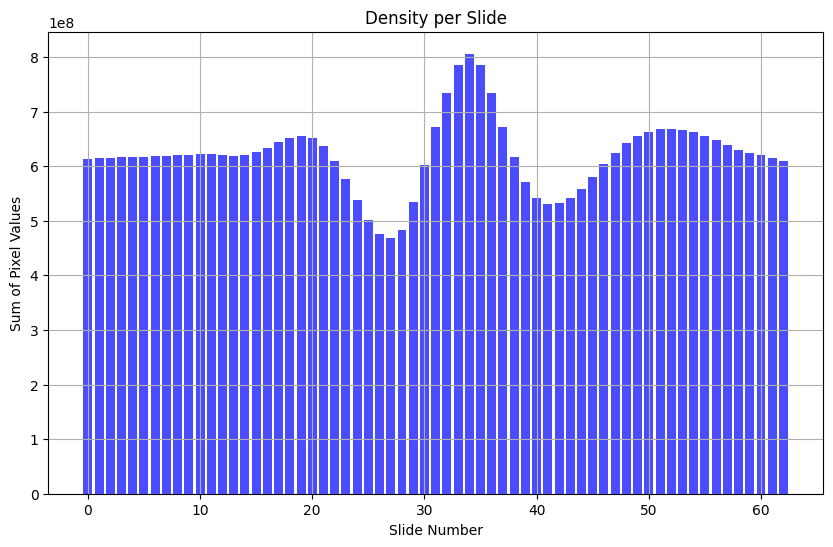

In [26]:
def plot_slide_sums(slide_sums):
    num_files = len(slide_sums)
    
    # Create an array for the x-axis (slide numbers)
    slide_numbers = np.arange(num_files)
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(slide_numbers, slide_sums, color='blue', alpha=0.7)
    plt.title('Density per Slide')
    plt.xlabel('Slide Number')
    plt.ylabel('Sum of Pixel Values')
    plt.grid(True)
    plt.show()

def calculate_slide_sums(volume):
    num_slices = volume.shape[2]
    slide_sums = np.empty(num_slices)
    
    for i in range(num_slices):
        slide = np.squeeze(volume[:, :, i])
        slide_sums[i] = np.sum(slide)
        
    return slide_sums


# Calculate the sums for each slide in the volume
slide_sums = calculate_slide_sums(volume)

# Plot the sums for each slide
plot_slide_sums(slide_sums)


Now, let's introduce a new graph that offers even greater precision: the z-scores of density compared to the average signal provided by the papyrus.

This graph serves as a **laser pointer**, precisely indicating which areas hold the highest information content. When examining an empty papyrus, we would expect to observe a relatively flat z-score graph, as the density remains consistent throughout.

By calculating the z-scores and plotting them against the average signal, we gain a powerful tool to identify the most significant regions within the volume. Areas with high positive z-scores stand out as peaks, representing regions with a significantly higher density of INFORMATION than the average signal, suggesting the presence of relevant content, maybe ink.

Conversely, regions with low or negative z-scores are represented as valleys on the graph. These valleys correspond to areas with lower density compared to the average, potentially indicating regions with less relevant information.

By examining this z-score graph, we can accurately pinpoint the precise areas that contain the most valuable information within the papyrus. If there are letters somewhere, it should be there.


The first peak from the left in the differential density map typically corresponds to the supporting material, the papyrus itself; the second one, following the valley between the peaks, generally represents the presence of ink or other significant features on the papyrus. This peak indicates regions where the density sharply increases, signifying the areas where the ink has been applied. This is our lottery ticket.

Every sample is different, and the way it was processed may affect the result and makes the sample unique. 
Sometimes, we may encounter very sharp peaks in the z-score graph, indicating areas with extremely high density. While these peaks may initially seem promising, it is important to note that excessively dense information could hinder its value.

That's why we included in previous steps the skewing, gradients, and thresholding of the data. These techniques help to keep the sweet spot where the info is valuable, and can help to highlights regions that otherwise are invisible.

Ideally we should aim for a +2 z-score in the second peak from the left.

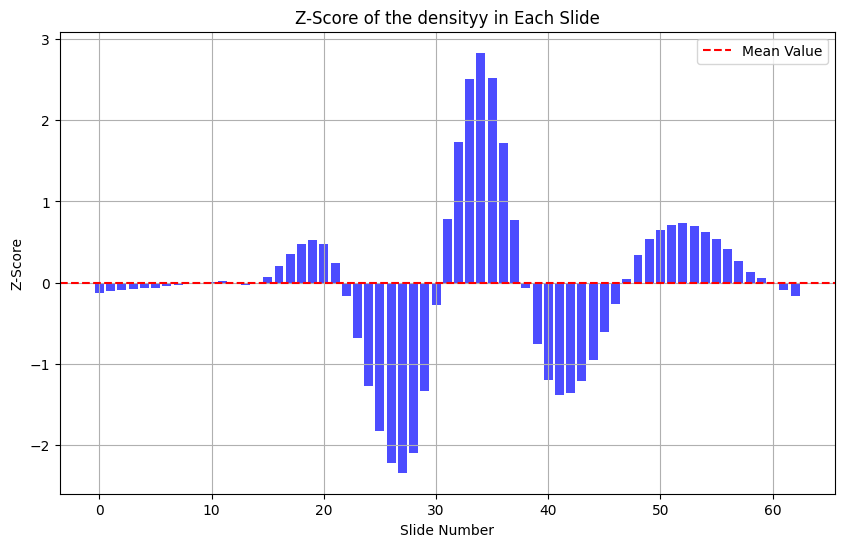

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_z_score_histogram(z_scores):
    num_files = len(z_scores)
    
    # Create an array for the x-axis (slide numbers)
    slide_numbers = np.arange(num_files)
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(slide_numbers, z_scores, color='blue', alpha=0.7)
    
    # Add a red horizontal line at the mean value (which should be around 0 after standardization)
    plt.axhline(0, color='red', linestyle='--', label='Mean Value')
    
    plt.title('Z-Score of the densityy in Each Slide')
    plt.xlabel('Slide Number')
    plt.ylabel('Z-Score')
    plt.grid(True)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

def calculate_z_scores(volume):
    num_slices = volume.shape[2]
    slide_sums = np.empty(num_slices)
    
    for i in range(num_slices):
        slide = np.squeeze(volume[:, :, i])
        slide_sums[i] = np.sum(slide)

    # Standardize slide_sums by subtracting the mean and dividing by the standard deviation
    z_scores = (slide_sums - np.mean(slide_sums)) / np.std(slide_sums)
        
    return z_scores


# Calculate the z-scores for each slide in the volume
z_scores = calculate_z_scores(volume)

# Plot the z-scores for each slide
plot_z_score_histogram(z_scores)


Finally, armed with the gathered information, we can provide the program with a range of slices that show promising data.

Using this selected range of slices, the program can generate a differential density map of our volume. 

we can later finetune the projection, increasing the range or playing with the density parameters. Future versions of this program would ideally make this analysis interactively, to a quicker explorations.

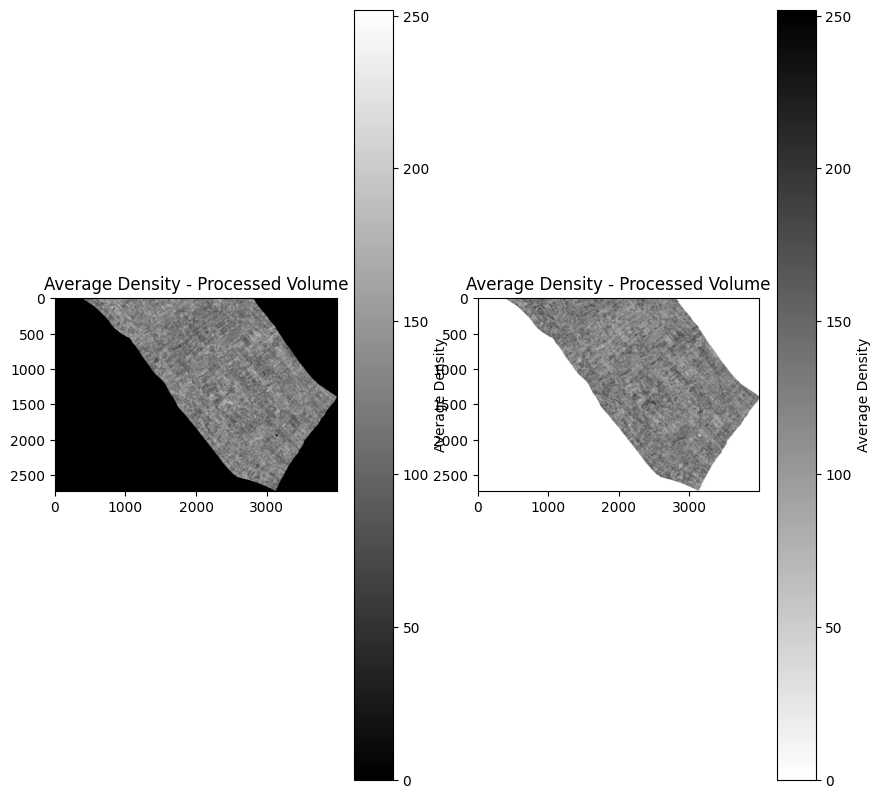

In [28]:
slice_range = slice(26,45)  
avg_density = calculate_average_density(volume, slice_range)



# Plot to compare before and after, in positive and inverse color mapping
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(avg_density, cmap='gray')
plt.title('Average Density - Processed Volume')
plt.colorbar(label='Average Density')


plt.subplot(1, 2, 2)
plt.imshow(avg_density, cmap='binary')
plt.title('Average Density - Processed Volume')
plt.colorbar(label='Average Density')

plt.show()

finally, we can export our slide for further analysis.

In [29]:
from PIL import Image
import numpy as np

# If  image is in float format
if avg_density.dtype.kind == 'f':
    avg_density = (255 * (avg_density - np.min(avg_density)) / np.ptp(avg_density)).astype(np.uint8)

# Create an Image object from the NumPy array
img = Image.fromarray(avg_density)

# Save the image as a TIFF file
img.save("%s_%s_%s_%s_%s_%s.tiff" % (input_folder_name, slice_range.start, slice_range.stop, gradient_method.__name__ , skew_value, opacity ))


In [14]:
# Save the processed slices as TIFF files in the alpha_folder

# Create a folder to save the alpha slices with gradient channel
# afn= input_folder_name + '_alpha_slices'
# alpha_folder = Path(afn)
# alpha_folder.mkdir(parents=True, exist_ok=True)
# save_slices_as_tiff(volume, alpha_folder)

From here, the rest is a matter of slicing, stacking and adjust the data in a creative suite such as Photoshop or Gimp, adjusting Levels, rotating and cropping the interesting areas.

I labelled tentatively the letters clearly visible, maybe forming a word similar to BEPAMV/BEPAMY. The rest of the letters are tabulated in rows and columns matching those characters so it's reasonable to assume that is text and not a (human) hallucination. 

Here you have the labelled and unlabelled versions of this crop, plus the gimp with all the historial of changes of the file to achieve the result displayed.

![Unlabelled](https://github.com/jomdh/scroll_density_analysis/blob/master/crop_unlabelled_layers_26_45_skewed_linear_gradient_1_0.4.png)


![Labelled](https://github.com/jomdh/scroll_density_analysis/blob/master/crop_labelled_layers_26_45_skewed_linear_gradient_1_0.4.png)

Gimp File: https://github.com/jomdh/scroll_density_analysis/blob/master/layers_26_45_skewed_linear_gradient_1_0.4.xcf
